![WoW](https://upload.wikimedia.org/wikipedia/ru/2/22/World_of_Warcraft_logo.png)

Задача спрогнозировать победу игрока World Of Warcraft (режим Поле боя) по его данным за матч и выявить признаки, которые сильнее всего влияют на победу.

Поле боя - это специальная территория для сражений между игроками противоположных фракций.Оказавшись внутри, две команды будут участвовать в масштабных сражениях, с различными целями (Захват флага, удерживание точек, сбор ресурсов и т.д). Игроки будут зарабатывать очки чести для покупки PvP брони и оружия.

Зная оптимальные для победы признаки можно более осознано подходить к выбору персонажа и знать на какие стратегии нужно сильнее приложиться, чтобы выиграть матч.

[Ссылка на данные](https://www.kaggle.com/cblesa/world-of-warcraft-battlegrounds)

### Описание данных
- Faction: Фракция (Орда или Альянс)
- Class: Класс персонажа
- KB: Количество смертельных убийств, данных игроком
- D: Сколько раз игрок умер
- HK: Количество убийств, в которых участвовал игрок или его группа.
- DD: Урон, нанесенный игроком за всю игру
- HD: Очки жизни, которые игрок востановил за всю игру
- Honor: Очки чести, полученные игроком
- Won: выиграла ли команда
- Rol: Роль игрока 
    - dps если игрок наносил урон;
    - heal, если игрок исцелял союзников
- BE: в течение нескольких недель происходит бонусное событие, когда увеличивается вознаграждение. 1, если битва произошла на этой неделе.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, recall_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline


## Загрузка данных

In [2]:
data = pd.read_csv('./data/wowbgs.csv')

# преобразуем два бинарных признака в один бинарный
data['Won'] = data['Win'] == 1.0
del data['Win']
del data['Lose']
del data['Code']

data.head()

,Battleground,Faction,Class,KB,D,HK,DD,HD,Honor,Rol,BE,Won
0,WG,Horde,Hunter,1,3,14,48155,6641,532,dps,NaN,True
1,WG,Horde,Death Knight,1,3,12,27025,7106,377,dps,NaN,True
2,WG,Alliance,Paladin,0,1,19,824,93879,252,heal,NaN,False
3,WG,Alliance,Paladin,1,2,25,7046,98599,274,heal,NaN,False
4,WG,Alliance,Rogue,2,3,23,65483,19629,268,dps,NaN,False


### Преобразование признаков

In [3]:
for col in ['Battleground', 'Faction', 'Class', 'Rol', 'BE']:
    enc = LabelEncoder()
    data[col] = enc.fit_transform(data[col])
data.head()

,Battleground,Faction,Class,KB,D,HK,DD,HD,Honor,Rol,BE,Won
0,8,1,3,1,3,14,48155,6641,532,0,188,True
1,8,1,0,1,3,12,27025,7106,377,0,2022,True
2,8,0,6,0,1,19,824,93879,252,1,2023,False
3,8,0,6,1,2,25,7046,98599,274,1,2024,False
4,8,0,8,2,3,23,65483,19629,268,0,2025,False


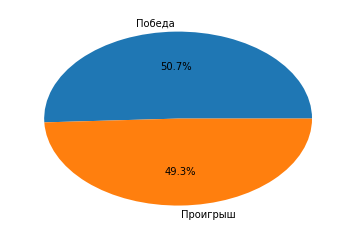

In [4]:
# Распределение результатов матчей
plt.pie(data['Won'].value_counts(), labels=['Победа', 'Проигрыш'], autopct='%1.1f%%');

In [5]:
# Добавим новый признак DamageRate, показывающий, 
# насколько сильно игрок помогал союзникам (учавствовал в командной игре)
# чем он ближе к 1.0, тем сильнее игрок был вовлечен в командную игру
data['DamageRate'] = data['HK'] / data['DD']
data['DamageRate'][data['DamageRate'] == np.inf] = 0
data['DamageRate'][data['DamageRate'].isnull()] = 0

/Users/pituganov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/pituganov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


По графику видно, что классы уже сбалансированы.

## Визуальный анализ данных

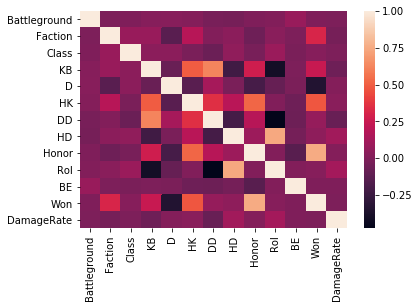

In [6]:
# посмотрим на корреляцию признаков
sns.heatmap(data.corr());

Можно заметить, что такие признаки связанные с нанесением урона довольно сильно коррелируют друг с другом.

Итого, получаем, что с победой сильнее всего коррелируют следующие признаки:
- Количество смертей
- Очки чести
- Количество убийств, в которых участвовал игрок

Также, по логике, на победу должно влиять количество урона, нанесенное игроком.

/Users/pituganov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


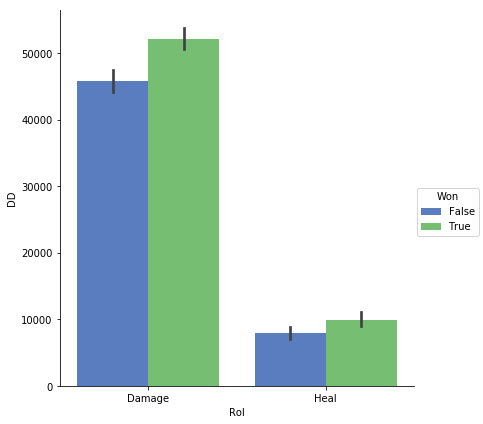

In [7]:
rol_data = data[['Rol', 'DD', 'Won']]
rol_data['Rol'] = rol_data['Rol'].map({0: "Damage", 1: "Heal"})
sns.factorplot(x="Rol", y='DD', hue='Won', data=rol_data, size=6, kind="bar", palette="muted");

По распределению наносимого урона между разными ролями видно, что игроки, которые занимаются исцелением союзников наносят куда меньше урона, чем остальные. 

Плюс игроки, которые выигрывают матчи, наносят больше урона, чем проигравшие.
<img src="https://memegenerator.net/img/instances/69532381/thank-you-captain-obvious.jpg" alt="Obvious" style="width: 300px;"/>

Отобразим парное распределение признаков, коррелирующих с целевой переменной.

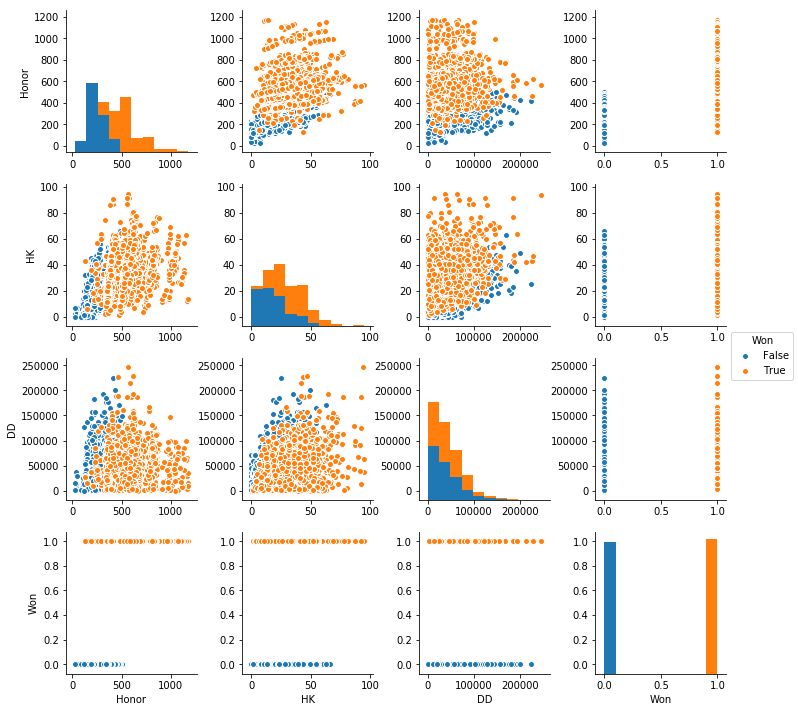

In [8]:
sns.pairplot(data[['Honor', 'HK', 'DD', 'Won']], hue="Won");

По этим графикам можно увидеть, что нужный класс хорошо выделяется.

Из этого можно сделать вывод, что для алгоритмов машинного обучения данная задача не будет сложной.

In [9]:
# проверяем наличие пропусков
for col in data.columns:
    print(col, data[col].isnull().sum())

Battleground 0
Faction 0
Class 0
KB 0
D 0
HK 0
DD 0
HD 0
Honor 0
Rol 0
BE 0
Won 0
DamageRate 0


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedKFold(n_splits=4)

X = data[list(set(data.columns) - set(['Won']))]
y = data['Won']

# На графиках видно, что искомый класс не сложно отделить.
# Попробуем усложнить задачу, взяв в качестве отложенной выборки половину всех данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=17, shuffle=True)

# Масштабируем признаки
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Будем использовать случайный лес, тк с его помощью мы сможем легко выяснить какие признаки привнесли наибольший вклад.

В качестве метрики будем использовать `recall` (True Positive Rate): 

${\mathit {TPR}}=\frac{\mathit {TP}}{P}=\frac{{\mathit {TP}}}{({\mathit {TP}}+{\mathit {FN}})}$, тк мы решаем задачу бинарной классификации и нам наиболее важно научиться определять победу игрока.

In [11]:
forest = RandomForestClassifier(random_state=17)
forest_params = {
    'n_estimators': list(range(40, 50)),
    'max_depth': list(range(10, 15)),
}
forest_grid = GridSearchCV(forest, forest_params, scoring='recall', cv=cv)
forest_grid.fit(X_train, y_train)
clf = forest_grid.best_estimator_

## Кривые обучения и валидации

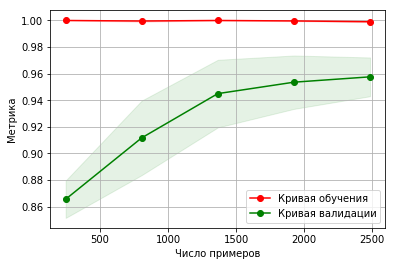

In [12]:
from sklearn.model_selection import learning_curve

plt.figure()
train_sizes, train_scores, test_scores = learning_curve(
    clf, X, y, n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.xlabel("Число примеров")
plt.ylabel("Метрика")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Кривая обучения")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Кривая валидации")

plt.legend(loc="best")
plt.show()

## Проверка модели на отложенной выборке

recall_score: 0.9823
             precision    recall  f1-score   support

      False       0.98      0.98      0.98       900
       True       0.99      0.98      0.98       963

avg / total       0.98      0.98      0.98      1863



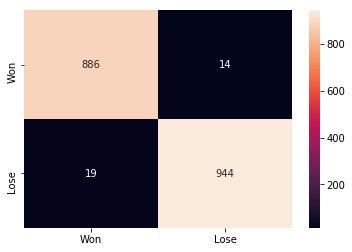

In [18]:
y_test_predict = clf.predict(X_test)

# Посмотрим на качество модели на отложенной выборке
print('recall_score:', round(clf.score(X_test, y_test), 4))

print(classification_report(y_test, y_test_predict))

cm = confusion_matrix(y_test, y_test_predict);
labels = ['Won', 'Lose']
sns.heatmap(pd.DataFrame(cm, columns=labels, index=labels), annot=True, fmt='d');

In [14]:
from sklearn.metrics import accuracy_score
print('recall на отложенной выборке:', recall_score(y_test, y_test_predict))

recall на отложенной выборке: 0.980269989616


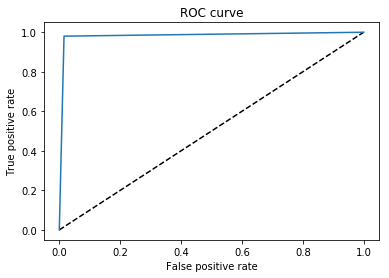

In [15]:
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_test_predict)

plt.plot([0, 1], [0, 1], 'k--');
plt.plot(fpr_rf_lm, tpr_rf_lm);
plt.xlabel('False positive rate');
plt.ylabel('True positive rate');
plt.title('ROC curve');

## Определение вклада каждого признака

In [16]:
feature_importances = []
for i, col in enumerate(list(set(data.columns) - set(['Won']))):
    feature_importances.append(round(clf.feature_importances_[i], 4))
pd.DataFrame(
    feature_importances,
    columns=['Importance'],
    index=list(set(data.columns) - set(['Won']))
).sort_values(by=['Importance'],ascending=False)

,Importance
Honor,0.5954
HK,0.0958
Faction,0.0677
D,0.0540
DamageRate,0.0475
BE,0.0292
Battleground,0.0280
DD,0.0255
HD,0.0228
KB,0.0216



## Выводы

Построена модель бинарного классификатора, предсказывающего результат матча в игре World Of Warcraft.
На отложенной выборке получили долю правильных предсказаний 0.98%, что является очень хорошим показателем.

Получаем, чтобы победить в групповом сражении в MMO игре, стоит делать больший упор не на увеличение наносимого урона, а на коммандную игру (помогать союзникам наносить урон и зарабатывать очки чести).

<img src="https://301-1.ru/img_files/gifs/2014_12_23_ea801005ae2a8b2ad07f850629b6639c.gif" alt="" style="width: 300px;"/>

Также с помощью построенной модели можно по статистике игрока предсказывать результат сражения.